# Week 3: CNN Cancer Detection Kaggle Mini-Project

# Purpose 
The purpose of this project is to develop an algorithim that can detect cancerous cells from snippets of images that belong to larger digital pathology scans. The dataset contains a "train" and "test" folder with TIFF image files, as well as a Training label csv file and a sample Submission csv file. 

In order to do so we will be utilizing a CNN (convolution neural network) framework to perform Image analysis and classification. Data for this project was taken from the [following Kaggle Competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) which evaluates test submissions by area under the ROC curve between the predicted probability and the observed target.


Participation in this competition past it's due date is part of completion for CU Boulder Intro to Deep Learning course - Week 3 content. Data Files and saved models can be found in the following [Github Repo](https://github.com/ancr8790/CancerDetection_CNN)


Let's take a closer look at the data...

### Import Necessary Libraries and setting up notebook environment

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import keras

2024-02-18 02:47:04.606034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 02:47:04.606262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 02:47:04.777248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import sklearn
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AvgPool2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, ReLU

import tensorflow as tf 
import tensorflow_io as tfio
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
# Detect hardware and light up the GPUs/TPUs
#code implemented from https://www.kaggle.com/code/toddgardiner/binary-cancer-classifier
try:
     # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

    # instantiate a distribution strategy
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
 
    # tell us what happened
    print('Running on TPU ', tpu.cluster_spec().as_dict())

except ValueError: # If TPU not found
    tpu = None
    tpu_strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
    print('Running on CPU instead')

print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)
print("TPU: ", tpu)

Running on CPU instead
Number of accelerators:  1
TPU:  None


In [8]:
#check current directory, change if necessary
parent_path = "/kaggle/input/histopathologic-cancer-detection"
train_path = "/kaggle/input/histopathologic-cancer-detection/train"
test_path = "/kaggle/input/histopathologic-cancer-detection/test"

os.chdir(parent_path)
print(os.getcwd())

/kaggle/input/histopathologic-cancer-detection


## Import Data

In [9]:
#Import data from csv file
hcd_train = pd.read_csv('train_labels.csv')
#display first 5 rows to confirm
print("Training Labels")
display(hcd_train.head(5))

hcd_test = pd.read_csv('sample_submission.csv')
#display first 5 rows to confirm
print("Sample Submission for Testing Data")
display(hcd_test.head(5))

Training Labels


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Sample Submission for Testing Data


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [10]:
print("rows, columns of Train csv file:", hcd_train.shape)
print("# of scans in Train folder:", len(os.listdir(train_path)))
print("unique label values:", hcd_train['label'].unique())

rows, columns of Train csv file: (220025, 2)
# of scans in Train folder: 220025
unique label values: [0 1]


In [11]:
print("rows, columns of Test csv file:", hcd_test.shape)
print("# of scans in Test folder:", len(os.listdir(test_path)))

rows, columns of Test csv file: (57458, 2)
# of scans in Test folder: 57458


Here we see that Train data csv file has 2 attributes: 'ID' referring to the image scan name and "Label" which has the labels for cancerous or noncancerous cells using a binary [0,1] system. This indicates we should be creating a binary classification algorithim for this problem. We also confirmed the length of the label file is equal to the number of scans in the training folder (220,025).

For the Test data set, we used the sample submission csv file to confirm the number of the scans(57,458) in the testing folder and the submission format as expected for the Kaggle submission. Next we will take a look at the images in the Train and Test folders to understand the data we are working with.

Typical train image properties
image type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Converted image array datatype: float32
Array shape: (96, 96, 3)


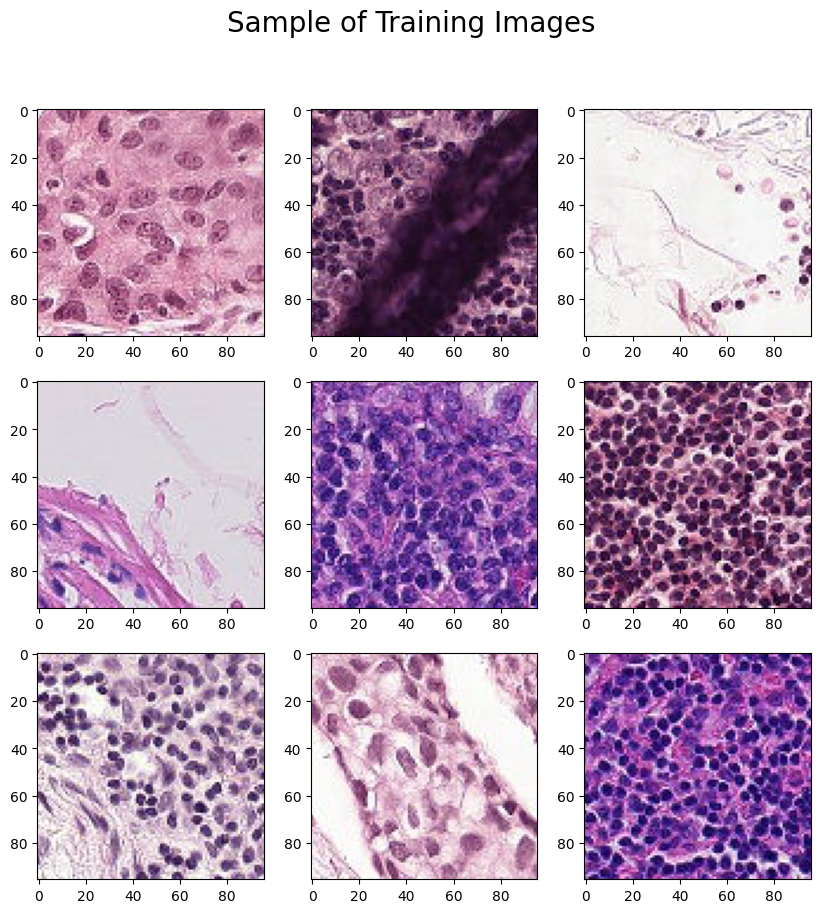

In [12]:
#go into Train folder
os.chdir(train_path)
dir_list = os.listdir(train_path)
#display typical training images
print("Typical train image properties")
img = load_img(dir_list[0])
print("image type:", type(img))
img_array = img_to_array(img)
print("Converted image array datatype:", img_array.dtype)
print("Array shape:", img_array.shape)

fig, axs = plt.subplots(3,3,figsize=(10, 10))
h = 0
v = 0
for i in range(0,9):
    img = load_img(dir_list[i])
    axs[h,v].imshow(img)
    if h == 2:
        v +=1
        h = 0
    else: 
        h += 1
fig.suptitle("Sample of Training Images", fontsize = 20)
plt.show()

Typical test image properties
image type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Converted image array datatype: float32
Array shape: (96, 96, 3)


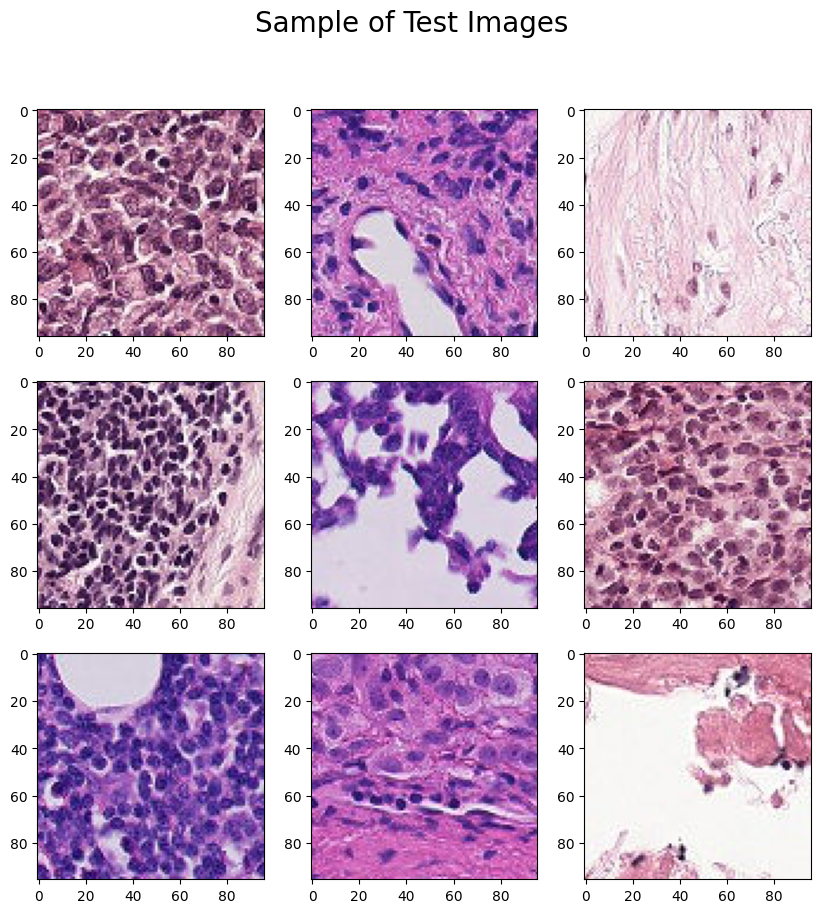

In [13]:
#go into Test folder
os.chdir(test_path)
dir_list = os.listdir(test_path)
#display typical testing images
print("Typical test image properties")
img = load_img(dir_list[0])
print("image type:", type(img))
img_array = img_to_array(img)
print("Converted image array datatype:", img_array.dtype)
print("Array shape:", img_array.shape)

fig, axs = plt.subplots(3,3,figsize=(10, 10))
h = 0
v = 0
for i in range(0,9):
    img = load_img(dir_list[i])
    axs[h,v].imshow(img)
    if h == 2:
        v +=1
        h = 0
    else: 
        h += 1
fig.suptitle("Sample of Test Images", fontsize = 20)
plt.show()

In both datasets the images are loaded in as 96 x 96 Tiff Images and appear relatively uniform. Given the large amount of images in each data folder, for the purposes of future modeling it would be most efficient to load the images in batches to conserve memory.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 


In [14]:
hcd_train.isna().sum()

id       0
label    0
dtype: int64

Initial exploratory analysis there are no null values in the training set and therefore no adjustments needed. 

In [15]:
display(hcd_train.describe())

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Initial description of the data reports a mean of 0.40 indicating a slight distribution bias towards the noncancerous label. Let's dive deeper into what the exact distribution looks like. 

In [16]:
#determine distribution of class variable
temp_df = pd.DataFrame()
temp_df['Class'] = np.where(hcd_train['label'] == 0, "NonCancerous", "Cancerous")
class_df = temp_df['Class'].value_counts().rename_axis('Class').reset_index(name = 'count')
class_df['Distribution'] = class_df['count']/sum(class_df['count'])
print(class_df)

          Class   count  Distribution
0  NonCancerous  130908      0.594969
1     Cancerous   89117      0.405031


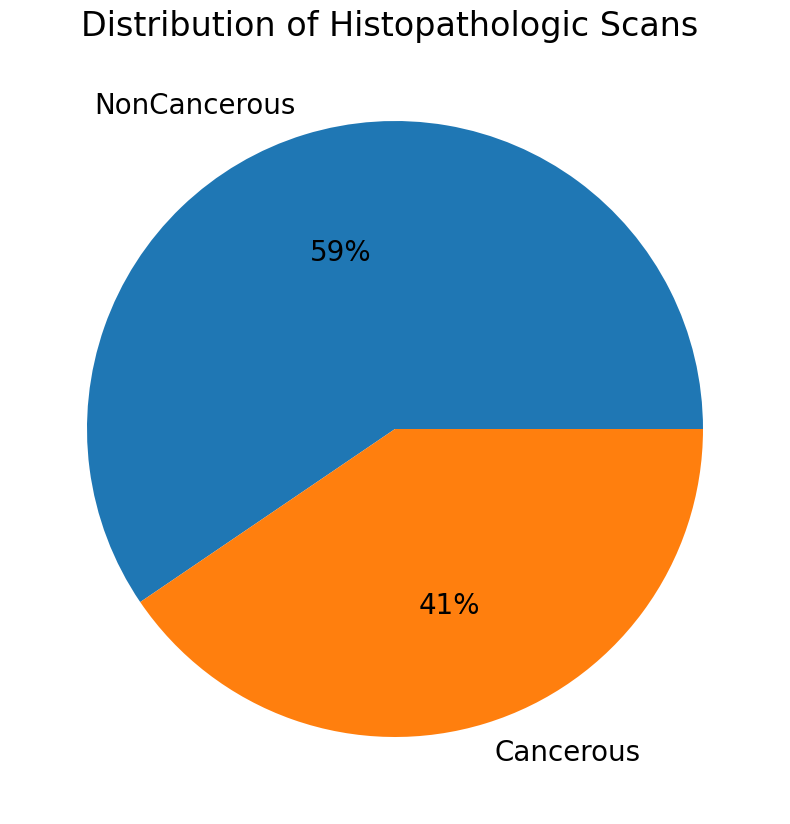

In [17]:
fig,ax = plt.subplots(figsize = (10,10))
plt.rc('font', size=20) 
plt.pie(class_df['count'], labels = class_df['Class'], autopct = '%1.0f%%')
plt.title("Distribution of Histopathologic Scans ")
plt.show()
#plt.savefig('Distribution_hcd.png')

Here we see that the data has a relatively even distribution of Cancerous vs Noncancerous image scans (40/60), leaning slight more in the Noncancerous direction. Having a balance training dataset will help prevent the model from becoming biased towards one particular class. If we wanted to even the training set further, we could undersample from the Noncancerous set to equalize with the cancerous set. 

Based on this EDA, we have made the following observations:
* We have a substantial amount of training data to work with (220,000+)
* The Training data set has a slightly skewed distribution towards Noncancerous images (60/40).
    * We could undersample from the Noncancerous images to even out the distribution 
* We need to split the Train set into a training and validation dataset. 
* The labels have only 2 unique values therefore we will be building a binary classification model. 
* The ID's in the csv files provide the file name without the ".tif" suffix
* Given the large amount of images in each data folder, loading the entire train and test folder at once would have heavy strain on memory and would likely slow the system down considerable. Loading in batches will hopefully mitgate this.

My plan for Initial Model implementation will be as follows:
* Split Train data into a 80/20 Training/Validation set
    * dataset will be reduced for each category to have a maximum of the minority group (Cancerous) so that the distribution is equal
* Set up CNN architecture with initial hyperparameters 
* Train CNN with batched training folder scans to make predictions
* evaluate CNN predictions with training labels for accuracy
    * Plot loss function
    * Plot Accuracy
* Run CNN model on Validation data
* iterate through tuning hyperparameters and/or different architectures to increase accuracy

# Data Preprocessing

First let's split up the Train dataset with a 80/20 set up. When previous iterations of training with full slightly skewed distribution for training and evaluation, the training time was taking too long and the evalutation metrics were performing poorly.  Here we split the train dataset based on total observations of Cancerous observations (89,117).

In [18]:
canc_tot = hcd_train.label.sum()
print("Total Cancerous Observations:",canc_tot )
split_80 = int(canc_tot*0.8)
split_20 = int(canc_tot*0.2)

print("80% of these cancerous observations (",split_80,") will go to the Training data")
print("20% of these cancerous observations (",split_20,") will go to the Validation data")

random_seed = 123
noncanc = hcd_train[hcd_train['label'] ==0]
canc = hcd_train[hcd_train['label'] ==1]
noncanc_samp = noncanc.sample(n = canc_tot, random_state = random_seed)
train_bal = pd.concat([canc, noncanc_samp]).sample(frac=1, random_state=random_seed).reset_index(drop=True)


Total Cancerous Observations: 89117
80% of these cancerous observations ( 71293 ) will go to the Training data
20% of these cancerous observations ( 17823 ) will go to the Validation data


In [19]:
print("Confirming", noncanc.label.sum(), "Cancerous observations in noncancerous data set of", len(noncanc), "observations")
print("Confirming",canc.label.sum(),"Cancerous observations in cancerous data set of", len(canc), "observations")
print(len(noncanc_samp), "observations were sampled from the noncancerous dataset")

Confirming 0 Cancerous observations in noncancerous data set of 130908 observations
Confirming 89117 Cancerous observations in cancerous data set of 89117 observations
89117 observations were sampled from the noncancerous dataset


In [20]:
#determine distribution of class variable
print("Reduced Sample Dataset Class Distribution:")
print(train_bal.label.value_counts(normalize = True))

Reduced Sample Dataset Class Distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


Initially, it had seemed that by applying the train_test_split function to a balanced dataset, the result split datasets would also inherit that underlying distribution. I was proven wrong when training models later on in the notebook because the training dataset ended up with the original 60/40 distribution. This was mitigated by applying "stratify" to the train_test_split function, and recombining the separated data. The distribution was determined to be correctly balanced this time.

In [21]:
#split up labelled Train data 
X = train_bal['id']
y = train_bal['label']
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size = 0.20, random_state = random_seed,stratify = y)
# Print class distribution in the original dataset
print("Original Dataset Class Distribution:")
print(train_bal.label.value_counts(normalize=True))

# Print class distribution in the training and validation sets
print("\nTraining Set Class Distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation Set Class Distribution:")
print(y_val.value_counts(normalize=True))

Original Dataset Class Distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Training Set Class Distribution:
label
1    0.500004
0    0.499996
Name: proportion, dtype: float64

Validation Set Class Distribution:
label
0    0.500014
1    0.499986
Name: proportion, dtype: float64


In [22]:
#combined singular arrays into dataframe and confirm distributions
hcd_train = {'id': X_train, 'label': y_train}
hcd_train =pd.DataFrame(hcd_train)
print("\nTraining Set Class Distribution:")
print(hcd_train.label.value_counts(),hcd_train.label.value_counts(normalize=True))

hcd_val= {'id': X_val, 'label': y_val}
hcd_val=pd.DataFrame(hcd_val)
print("\nValidation Set Class Distribution:")
print(hcd_val.label.value_counts(),hcd_val.label.value_counts(normalize=True))


Training Set Class Distribution:
label
1    71294
0    71293
Name: count, dtype: int64 label
1    0.500004
0    0.499996
Name: proportion, dtype: float64

Validation Set Class Distribution:
label
0    17824
1    17823
Name: count, dtype: int64 label
0    0.500014
1    0.499986
Name: proportion, dtype: float64


Next, I create helper functions that allow us to map the path to a respective image based on the ID of the observations and another function to use that determined path to load the image and convert it into a tensor for later usage.

In [23]:
#define function to retrieve path to image file based on ID
def get_path(id, parentPath):
    filename = id+".tif"
    path = parentPath+"/"+filename

    return(path)

#test function
hcd_train['path'] = get_path(hcd_train['id'],train_path)
hcd_val['path'] = get_path(hcd_val['id'],train_path)
print(hcd_train.iloc[0]['path'])
display(hcd_train.iloc[0])

/kaggle/input/histopathologic-cancer-detection/train/7287ea7c335d99152921c28557dad3cd45c56f67.tif


id                7287ea7c335d99152921c28557dad3cd45c56f67
label                                                    1
path     /kaggle/input/histopathologic-cancer-detection...
Name: 32042, dtype: object

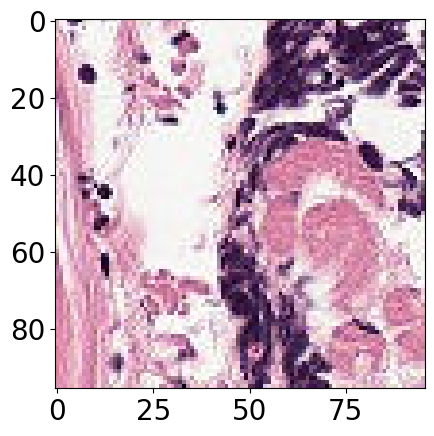

Tensor shape (96, 96, 3)


In [24]:
#define function to load image, convert to array 
def load_image(path):
    file = tf.io.read_file(path)
    #decode TIFF (Tagged Image File Format) image into a tensor.
    img = tfio.experimental.image.decode_tiff(file, index=0)
    #add randomization sampling of images in different vertical and horiztontal positioning
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    #image has additional channels to RGB, extract first 3 layers for purpose of CNN
    img =img[:,:,0:-1]
    #to show using matplot lib normalization of 0-1 is necessary (i.e. divide by 255)
    img = img/255
    #convert data type to float
    img = tf.image.convert_image_dtype(img,dtype=tf.float32)
    return img

#test out function
file = get_path("6e340f3cd1fc70c3831b7be15031fe5e3bcfe6a0",train_path)
test_func = load_image(file)
plt.imshow(test_func)
plt.show()
print("Tensor shape", test_func.shape)

Now I piece together the helper functions and the existing labelled training & validation data to create Tensor Datasets. The use of Datasets will allow me to use the Tensor package which makes implementing deep learning models more efficient.

In [25]:
#set up batched dataset for model training
tf.random.set_seed(random_seed)

hcd_train_labels = tf.data.Dataset.from_tensor_slices(hcd_train.label.values)
hcd_val_labels = tf.data.Dataset.from_tensor_slices(hcd_val.label.values)

hcd_train_paths = tf.data.Dataset.from_tensor_slices(hcd_train.path.values)
hcd_val_paths = tf.data.Dataset.from_tensor_slices(hcd_val.path.values)

hcd_train_imgs = hcd_train_paths.map(load_image)
hcd_val_imgs = hcd_val_paths.map(load_image)

hcd_trainset = tf.data.Dataset.zip((hcd_train_imgs,hcd_train_labels)).batch(64).prefetch(AUTOTUNE)
hcd_valset = tf.data.Dataset.zip((hcd_val_imgs,hcd_val_labels)).batch(64).prefetch(AUTOTUNE)

In [26]:
# get rid of dummy variables taking up memory
del file
del test_func
del temp_df
del class_df
del dir_list
#del data

# Model Architecture 


The images are of size 96x96. During preprocessing, the image matrix was converted to an array, rescaled with a [0,1] parameters, and reshaped to a 96x96x3 tensor. This will serve as the input into the network. 


Parameters to be tuned for additional upcoming models:
* Training:
    * Learning rate
       * (0.01 ~0.0001)
    * Loss to be monitored
        * since this is a binary classification problem we will target binary crossentropy
    * Patience
    * \# of epochs
* Architecture:
    * \# of convolution layers
    * \# of neurons
    * Different activation functions
        * ReLu/PReLu for hidden layers
        * Sigmoid/Softmax/Tanh/PreLu for outpit
* Optimization
    * Optimizers: Adam, RMSprop
* Regularization
    * L2 Regularization, Dropouts, Batch Normalization

Previously tested model implementations failed (very high loss and low accuracy) with the following architecture and hyperparameters:

Architecture
* 4 layers of [convolution-average pool] structure
* 2 hidden Dense layers with >64 units
* Final Activation = ReLu, TanH

Optimizer
* Adam

Callbacks
* Early stopping with patience = 3



# Model 1: Initial CNN implementation
Initial model was implemented w/ Keras Sequential with the following hyperparameters:
* 4 layers of [convolution-convolution-Average Pool] structure
* 3 dense of layers of Neurons
* Final Activation of Tanh

I started with a moderate amount of convolution layers and dense layers to offer balance of enough layers for features to recognized at reasonable detail level without overloading the computing system. Started off with a 3x3 kernel as the standard starting point. Also went with a final activation of TanH since it limited the output from [-1,1] which would be easily normalized to 0 and 1 classification.

After initial experimentation, the starting documented iteration was able to reach a reasonable loss trend but the validation accuracy was highly variable and never plateued which would indicate stabilization on training. I changed the final activiation function from TanH to Sigmoid to align the limitation of output to be between [0,1] for an even easier normalization of probability classification between 0 and 1. 

I next tried to change the following shown in model below:
* Final Activation of Sigmoid to align with binary classification of images
* increasing patience in early stopping callbacks 
* decreased initial learning rate (from 0.0002 to 0.00002) to try and slow the convergence down and offer stability in highly variable validation accuracy I was seeing previously
* decreased momentum to avoid overshooting and oscillations (from 0.15 to 0.015)


In [27]:
#define callbacks for future models
#initialize variable
checkpoint_filepath = ''
#Stops training when a monitored metric has stopped improving.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=5, restore_best_weights=True)
#Reduces the learning rate when a monitored metric has stopped 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='binary_crossentropy', factor=0.1, patience=3, min_lr=0)


In [28]:
with tpu_strategy.scope():
    model1 = Sequential([Input(shape = (96,96,3)),

    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
                        
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),

    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),

    #transition to Neural Network
    Flatten(),
    #can add regularization between dense layers to prevent overfitting
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    #can change final activation during tuning
    Dense(1, activation = 'sigmoid')
    ])

    model1.compile(
        optimizer = tf.keras.optimizers.experimental.RMSprop(
            learning_rate=0.00002,
            momentum=0.015,
            jit_compile=True),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy']
    )

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 average_pooling2d (Average  (None, 48, 48, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 average_pooling2d_1 (Avera  (None, 24, 24, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 average_pooling2d_2 (Avera  (None, 12, 12, 64)        0

In [ ]:
#time to train the model 
checkpoint_filepath1 = '/kaggle/working/model1/'
os.makedirs(checkpoint_filepath1,exist_ok = True)
#Saves the model's weights at specified intervals during training.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath1, save_weights_only=False, save_best_only=True)
CNN_callbacks = [model_checkpoint, early_stop, reduce_lr]


CNN1 = model1.fit(
                 hcd_trainset,
                 epochs = 30,
                 callbacks = CNN_callbacks,
                 validation_data = hcd_valset
                )

In [ ]:
#summarize accuracy & loss

acc = CNN1.history['accuracy']
val_acc = CNN1.history['val_accuracy']

loss = CNN1.history['loss']
val_loss = CNN1.history['val_loss']
epochs = range(len(acc))

cnn1_data = {"epoch": epochs, "accuracy": acc, "validation accuracy": val_acc, "loss": loss, "validation loss": val_loss}
CNN1_training = pd.DataFrame(cnn1_data)
CNN1_training.to_csv('/kaggle/working/CNN1_training.csv',index=False)

#fig, axs = plt.subplots(2, figsize=(10, 10))
plt.rc('font', size=20) 
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig('/kaggle/working/CNN1_accuracy.png')
plt.show()
#axs[0,0] = plt.show()
plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig('/kaggle/working/CNN1_loss.png')
plt.show()

Based on the accuracy and loss plots above, it looks like performance had been improving over the number of epochs. But we did not see any true convergence which would suggest there is still improvement to be made.
There is also a spike in loss and drop in accuracy around epoch 10 and 20. This could imply the model overshot it adjusting parameters, however it quickly readjusted itself and we don't see much else oscillations.



## Model 2

To adjust from the previous model, I increased the number of epochs trained (from 30 to 60) to get proper convergence and added some regularization in the form of batch normalization to help increase accuracy.

In [29]:
with tpu_strategy.scope():
    model2 = Sequential([Input(shape = (96,96,3)),

    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    BatchNormalization(),
    
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    BatchNormalization(),
                        
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    BatchNormalization(),
                         
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),

    #transition to Neural Network
    Flatten(),
    #can add regularization between dense layers to prevent overfitting
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    #can change final activation during tuning
    Dense(1, activation = 'sigmoid')
    ])

    model2.compile(
        optimizer = tf.keras.optimizers.experimental.RMSprop(
            learning_rate=0.00002,
            momentum=0.015,
            jit_compile=True),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy']
    )

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 average_pooling2d_7 (Avera  (None, 48, 48, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 average_pooling2d_8 (Avera  (None, 24, 24, 32)        0         
 gePooling2D)                                                    
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                      

In [ ]:
#time to train the model 
checkpoint_filepath2 = '/kaggle/working/model2/'
os.makedirs(checkpoint_filepath2,exist_ok = True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath2, save_weights_only=False, save_best_only=True)
CNN_callbacks = [model_checkpoint, early_stop, reduce_lr]


CNN2 = model2.fit(
                 hcd_trainset,
                 epochs = 60,
                 callbacks = CNN_callbacks,
                 validation_data = hcd_valset
                )

In [ ]:
#summarize accuracy & loss

acc = CNN2.history['accuracy']
val_acc = CNN2.history['val_accuracy']

loss = CNN2.history['loss']
val_loss = CNN2.history['val_loss']
epochs = range(len(acc))

cnn2_data = {"epoch": epochs, "accuracy": acc, "validation accuracy": val_acc, "loss": loss, "validation loss": val_loss}
CNN2_training = pd.DataFrame(cnn2_data)
CNN2_training.to_csv('/kaggle/working/CNN2_training.csv',index=False)

#fig, axs = plt.subplots(2, figsize=(10, 10))
plt.rc('font', size=20) 
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig('/kaggle/working/CNN2_accuracy.png')
plt.show()
#axs[0,0] = plt.show()
plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig('/kaggle/working/CNN2_loss.png')
plt.show()

The Training Accuracy and Loss functions for the training data set ended up looking smoother and achieving more of a plateau. It could appear to still be steadily increasing but the slope is getting fairly close to 0 (~0.07). The performance for the validation dataset ended up with a much higher oscilation rate than in the previous model, but this could also be exaggerated by the small scale of y values. Overall this model seems to be a good contender for using to predict full testing data. We will make minor adjustments to see if we can get the validation performance to reduce oscillations (increase batch size) and the training performance to more obviously plateau to a zero slope (increasing learning rate).

## Model 3

In this iteration, I increased the batch size from 64 to 128 and increased the learning rate from 0.00002 to 0.00005.

In [30]:
hcd_trainset_bb = tf.data.Dataset.zip((hcd_train_imgs,hcd_train_labels)).batch(128).prefetch(AUTOTUNE)
hcd_valset_bb = tf.data.Dataset.zip((hcd_val_imgs,hcd_val_labels)).batch(128).prefetch(AUTOTUNE)

In [31]:
with tpu_strategy.scope():
    model3 = Sequential([Input(shape = (96,96,3)),

    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    BatchNormalization(),
    
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    BatchNormalization(),
                        
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    BatchNormalization(),
                         
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),

    #transition to Neural Network
    Flatten(),
    #can add regularization between dense layers to prevent overfitting
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    #can change final activation during tuning
    Dense(1, activation = 'sigmoid')
    ])

    model3.compile(
        optimizer = tf.keras.optimizers.experimental.RMSprop(
            learning_rate=0.00005,
            momentum=0.015,
            jit_compile=True),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy']
    )

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 average_pooling2d_14 (Aver  (None, 48, 48, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 average_pooling2d_15 (Aver  (None, 24, 24, 32)        0         
 agePooling2D)                                                   
                                                                 
 batch_normalization_3 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                      

In [ ]:
#time to train the model 
checkpoint_filepath3 = '/kaggle/working/model3/'
os.makedirs(checkpoint_filepath3,exist_ok = True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath3, save_weights_only=False, save_best_only=True)
CNN_callbacks = [model_checkpoint, early_stop, reduce_lr]


CNN3 = model3.fit(
                 hcd_trainset_bb,
                 epochs = 60,
                 callbacks = CNN_callbacks,
                 validation_data = hcd_valset_bb
                )

In [ ]:
#summarize accuracy & loss

acc = CNN3.history['accuracy']
val_acc = CNN3.history['val_accuracy']

loss = CNN3.history['loss']
val_loss = CNN3.history['val_loss']
epochs = range(len(acc))

cnn3_data = {"epoch": epochs, "accuracy": acc, "validation accuracy": val_acc, "loss": loss, "validation loss": val_loss}
CNN3_training = pd.DataFrame(cnn3_data)
CNN3_training.to_csv('/kaggle/working/CNN3_training.csv',index=False)

#fig, axs = plt.subplots(2, figsize=(10, 10))
plt.rc('font', size=20) 
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig('/kaggle/working/CNN3_accuracy.png')
plt.show()
plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig('/kaggle/working/CNN3_loss.png')
plt.show()

This iteration produced very desirable training performance,(slopes of very nearly 0) however it seems to have overfit due to the increasing loss function we start to see after about 35 epochs. The training performance seems to plateau as far back as 30 epochs. To save on training time, for future models we can likely reduce the epochs back down to 40. 

I suspect the increase in batch size cause the even higher variability in the validation data. I will experiment to lower the batch size back down, but keep the higher learning rate. 

## Model 4

For this iteration, I lowered the batch size back down to 64 and decreased the epochs to 40.

In [32]:
with tpu_strategy.scope():
    model4 = Sequential([Input(shape = (96,96,3)),

    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    BatchNormalization(),
    
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    BatchNormalization(),
                        
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    BatchNormalization(),
                         
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),

    #transition to Neural Network
    Flatten(),
    #can add regularization between dense layers to prevent overfitting
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    #can change final activation during tuning
    Dense(1, activation = 'sigmoid')
    ])

    model4.compile(
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=0.00005,
            momentum=0.015,
            jit_compile=True),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy']
    )

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 average_pooling2d_21 (Aver  (None, 48, 48, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 average_pooling2d_22 (Aver  (None, 24, 24, 32)        0         
 agePooling2D)                                                   
                                                                 
 batch_normalization_6 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                      

In [ ]:
#time to train the model 
checkpoint_filepath4 = '/kaggle/working/model4/'
os.makedirs(checkpoint_filepath4,exist_ok = True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath4, save_weights_only=False, save_best_only=True)
CNN_callbacks = [model_checkpoint, early_stop, reduce_lr]


CNN4 = model4.fit(
                 hcd_trainset,
                 epochs = 40,
                 callbacks = CNN_callbacks,
                 validation_data = hcd_valset
                )

In [ ]:
#summarize accuracy & loss

acc = CNN4.history['accuracy']
val_acc = CNN4.history['val_accuracy']

loss = CNN4.history['loss']
val_loss = CNN4.history['val_loss']
epochs = range(len(acc))

cnn4_data = {"epoch": epochs, "accuracy": acc, "validation accuracy": val_acc, "loss": loss, "validation loss": val_loss}
CNN4_training = pd.DataFrame(cnn4_data)
CNN4_training.to_csv('/kaggle/working/CNN4_training.csv',index=False)

#fig, axs = plt.subplots(2, figsize=(10, 10))
plt.rc('font', size=20) 
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig('/kaggle/working/CNN4_accuracy.png')
plt.show()
#axs[0,0] = plt.show()
plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig('/kaggle/working/CNN4_loss.png')
plt.show()

This iteration again produced desirable training results but the validation performance is arguably worse than the previously model. It seems the direction I've taken with these last two models wasn't increasing performance so I decided to revert to the last best known model (2) and adjust different hyperparameters to increase performance. 

## Model 5

seeing as model 2 is the best performing so far, I decided to see if I could improve performance with a different regularization method. In this iteration I used Dropout. 

In [33]:
with tpu_strategy.scope():
    model5 = Sequential([Input(shape = (96,96,3)),

    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Dropout(0.2),
    
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Dropout(0.2),
                        
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Dropout(0.2),

    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),

    #transition to Neural Network
    Flatten(),
    #can add regularization between dense layers to prevent overfitting
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    #can change final activation during tuning
    Dense(1, activation = 'sigmoid')
    ])

    model5.compile(
        optimizer = tf.keras.optimizers.experimental.RMSprop(
            learning_rate=0.00002,
            momentum=0.015,
            jit_compile=True),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy']
    )

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 average_pooling2d_28 (Aver  (None, 48, 48, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_29 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 average_pooling2d_29 (Aver  (None, 24, 24, 32)        0         
 agePooling2D)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 24, 24, 64)       

In [ ]:
#time to train the model 
checkpoint_filepath5 = '/kaggle/working/model5/'
os.makedirs(checkpoint_filepath5,exist_ok = True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath5, save_weights_only=False, save_best_only=True)
CNN_callbacks = [model_checkpoint, early_stop, reduce_lr]


CNN5 = model5.fit(
                 hcd_trainset,
                 epochs = 15,
                 callbacks = CNN_callbacks,
                 validation_data = hcd_valset
                )

In [ ]:
#summarize accuracy & loss

acc = CNN5.history['accuracy']
val_acc = CNN5.history['val_accuracy']

loss = CNN5.history['loss']
val_loss = CNN5.history['val_loss']
epochs = range(len(acc))

cnn5_data = {"epoch": epochs, "accuracy": acc, "validation accuracy": val_acc, "loss": loss, "validation loss": val_loss}
CNN5_training = pd.DataFrame(cnn5_data)
CNN5_training.to_csv('/kaggle/working/CNN5_training.csv',index=False)

#fig, axs = plt.subplots(2, figsize=(10, 10))
plt.rc('font', size=20) 
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig('/kaggle/working/CNN5_accuracy.png')
plt.show()
#axs[0,0] = plt.show()
plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig('/kaggle/working/CNN5_loss.png')
plt.show() 

The implementation of Dropout as the regularization technique significantly improved the model's performance and stability. I could play around with the dropoutvalue to see if that further improves performance in the future. Epoch training time was also drastically reduced from previous sessions, and was originally ran at 5 epochs. I decided to increase just to observe behavior but it started to overfit so training to 5 -10 was sufficient.

## Model 6

In this model iteration, I added Dropout regularization layers in between the dense layers to further prevent overfitting. 

In [34]:
with tpu_strategy.scope():
    model6 = Sequential([Input(shape = (96,96,3)),

    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Dropout(0.2),
    
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Dropout(0.2),
                        
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),
    Dropout(0.2),

    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
    AvgPool2D(pool_size = 2, padding= 'same'),

    #transition to Neural Network
    Flatten(),
    #can add regularization between dense layers to prevent overfitting
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
    ])

    model6.compile(
        optimizer = tf.keras.optimizers.experimental.RMSprop(
            learning_rate=0.00002,
            momentum=0.015,
            jit_compile=True),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy']
    )

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 average_pooling2d_35 (Aver  (None, 48, 48, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_36 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 average_pooling2d_36 (Aver  (None, 24, 24, 32)        0         
 agePooling2D)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 64)       

In [ ]:
#time to train the model 
checkpoint_filepath6 = '/kaggle/working/model6/'
os.makedirs(checkpoint_filepath6,exist_ok = True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath6, save_weights_only=False, save_best_only=True)
CNN_callbacks = [model_checkpoint, early_stop, reduce_lr]


CNN6 = model6.fit(
                 hcd_trainset,
                 epochs = 10,
                 callbacks = CNN_callbacks,
                 validation_data = hcd_valset
                )

In [ ]:
#summarize accuracy & loss

acc = CNN6.history['accuracy']
val_acc = CNN6.history['val_accuracy']

loss = CNN6.history['loss']
val_loss = CNN6.history['val_loss']
epochs = range(len(acc))

cnn6_data = {"epoch": epochs, "accuracy": acc, "validation accuracy": val_acc, "loss": loss, "validation loss": val_loss}
CNN6_training = pd.Dataframe(cnn6_data)
CNN6_training.to_csv('/kaggle/working/CNN6_training.csv',index=False)

#fig, axs = plt.subplots(2, figsize=(10, 10))
plt.rc('font', size=20) 
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig('/kaggle/working/CNN6_accuracy.png')
plt.show()
#axs[0,0] = plt.show()
plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig('/kaggle/working/CNN6_loss.png')
plt.show() 

This model started with decent accuracy and had very favorable loss performance, and was able to be trained with much less epochs than the previous models. I would consider this the best performing model and would submit to the competition at this point with this performance.

## Set up submission data

In [ ]:
os.chdir(parent_path)
hcd_test = pd.read_csv('sample_submission.csv')

In [ ]:
#change directories to load saved models or load from working output directory. Uncomment line as appropriate
# os.chdir("/kaggle/input/cnn-trained-models")
# os.chdir("/kaggle/working")

In [ ]:
# Create submission file for one model

#create tf dataset of testing data 
hcd_test = hcd_test.drop('label',axis = 1)
hcd_test['path'] = get_path(hcd_test['id'],test_path)
hcd_test_paths = tf.data.Dataset.from_tensor_slices(hcd_test.path.values)

#batch test images
hcd_testset = hcd_test_paths.map(load_image).batch(64).prefetch(AUTOTUNE)

#create submission data for one model
with tpu_strategy.scope():
     model6 = tf.keras.models.load_model("/kaggle/working/model6")
        
pred6_raw = model6.predict(hcd_testset)
pred6 = (pred6_raw> 0.5).astype(int)

hcd_test = hcd_test.drop('path', axis = 1)

pred6_df = hcd_test.copy()
pred6_df['label'] = pred6

pred6_df.to_csv('/kaggle/working/Model6_submission.csv',index=False)

In [ ]:
# Create submission file for multiple models

# #create tf dataset of testing data 
# hcd_test = hcd_test.drop('label',axis = 1)
# hcd_test['path'] = get_path(hcd_test['id'],test_path)
# hcd_test_paths = tf.data.Dataset.from_tensor_slices(hcd_test.path.values)

# #batch test images
# hcd_testset = hcd_test_paths.map(load_image).batch(64).prefetch(AUTOTUNE)

# #load saved models
# with tpu_strategy.scope():
#     #model1 = tf.keras.models.load_model("/kaggle/input/cnn-trained-models/model1")
#     model2 = tf.keras.models.load_model("/kaggle/input/cnn-trained-models/model2")
#     model3 = tf.keras.models.load_model("/kaggle/input/cnn-trained-models/model3")
#     model4 = tf.keras.models.load_model("/kaggle/input/cnn-trained-models/model4")


# #make predictions
# #pred1_raw = model1.predict(hcd_testset)
# pred2_raw = model2.predict(hcd_testset)
# pred3_raw = model3.predict(hcd_testset)
# pred4_raw = model4.predict(hcd_testset)

# #convert logits to classification output
# #pred1 = (pred1_raw> 0.5).astype(int)
# pred2 = (pred2_raw> 0.5).astype(int)
# pred3 = (pred3_raw> 0.5).astype(int)
# pred4 = (pred4_raw> 0.5).astype(int)

# #create submission dataframes
# hcd_test = hcd_test.drop('path', axis = 1)

# # pred1_df = hcd_test.copy()
# # pred1_df['label'] = pred1

# pred2_df = hcd_test.copy()
# pred2_df['label'] = pred2

# pred3_df = hcd_test.copy()
# pred3_df['label'] = pred3

# pred4_df = hcd_test.copy()
# pred4_df['label'] = pred4

# #preview dataframes
# #print("mod1 predictions preview", pred1_df.head(5))
# print("mod2 predictions preview", pred2_df.head(5))
# print("mod3 predictions preview", pred3_df.head(5))
# print("mod4 predictions preview", pred4_df.head(5))

# #export to submission csv's
# #pred1_df.to_csv('/kaggle/working/Model1_submission.csv',index=False)
# pred2_df.to_csv('/kaggle/working/Model2_submission.csv',index=False)
# pred3_df.to_csv('/kaggle/working/Model3_submission.csv',index=False)
# pred4_df.to_csv('/kaggle/working/Model4_submission.csv',index=False)

## Results and Analysis 
A number of different models were run as in order to try detect histopathologic cancer with various hyperparameter tuning, different architectures, and application of various techniques to improve training or performance. A summary table of those results can be found in the table below. 

In all over 8 iterations of models were trained on with P100 GPU accelerator on >140,000 histopathologic tissue image snippets.
Initial models utilized layers of [convolution-average pool] structure, Final Activation functions of ReLu, TanH, and the Adam optimizer. These models did not perform well due to their high loss and low accuracy performance. The models performance started to improve once swtiching over to layers of [convolution-convolution-average pool] structure, an RMSprop optimizer, and a Sigmoid Final Activation Function. The sigmoid function likely worked better from a binary classification perspective because of its nature limiting values from [0,1]. I went with the RMSprop optimizer for its ability to provide fast convergence and stability in learning, since we were dealing with such a large amount of image files which take significant computing power and I was limited by the Kaggle quota. From there I experimented with lower learning rates, batch and epoch sizes, and regularization layers. While the learning rates and batch/epoch sizes had some effect on the performance, the largest improver was the switch from Batch Normalization to Dropout regularization technique. My thought of increasing learning rates and batch size to stabilize oscilating performance and achieve convergence quicker was proved to have the opposite effect and made the model's performance worse. At 2 iterations if worsening performance, I decided to abandoning optimizing epoch and batch sizes and revert to the previously best performing model and adjust other hyperparameters. That is wehn I discovered the alternate regularization method improved performance significantly.

In [3]:
model_sum = pd.DataFrame({
 'Architecture':['Model 0.1 CNN','Model 0.2 CNN','Model 1 CNN','Model 2 CNN',
                 'Model 3 CNN','Model 4 CNN','Model 5 CNN', 'Model 5.1 CNN',
                 'Model 6 CNN'],
 'Learning Rate':[.0002,.0002,.00002,.00002,
                  .00005,.00005,.00002,.00002,
                  .00002
                  ],
 'Final Activation Function':['ReLu','TanH','Sigmoid','Sigmoid',
             'Sigmoid','Sigmoid','Sigmoid','Sigmoid',
             'Sigmoid'
             ],
 'Optimizer':['Adam','Adam','RMSprop','RMSprop',
              'RMSprop','RMSprop','RMSprop','RMSprop',
              'RMSprop'
              ],
 'Epochs':[30,30,30,60,
           60,40,5,15,
           10,
           ],
    
 'Batch Size':[64,64,64,64,
           128,64,64,64,
           64,
           ],
'Regularization':['n/a','n/a','n/a','Batch Normalization',
                  'Batch Normalization','Batch Normalization','Dropout','Dropout',
                  'Dropout + in Dense Layers'
                  ],

 'Regularization value': ['n/a','n/a','n/a','n/a',
                    'n/a','n/a','0.2','0.2',
                    '0.2'],

 "Public LB":['Not Scored','Not Scored',50.02,63.24,
              43.98, 50, 78.68,78.44,
              80.44
                
          ],
 "Private LB":['Not Scored','Not Scored',50.04,59.28,
               43.64, 50, 72.35,73.21,
               74
                
          ],
 "Rank":[None,None,5,4,
         7,6,2,3,1,
        ]

 })

model_sum

,Architecture,Learning Rate,Final Activation Function,Optimizer,Epochs,Batch Size,Regularization,Regularization value,Public LB,Private LB,Rank
0,Model 0.1 CNN,0.00020,ReLu,Adam,30,64,n/a,n/a,Not Scored,Not Scored,NaN
1,Model 0.2 CNN,0.00020,TanH,Adam,30,64,n/a,n/a,Not Scored,Not Scored,NaN
2,Model 1 CNN,0.00002,Sigmoid,RMSprop,30,64,n/a,n/a,50.02,50.04,5.0
3,Model 2 CNN,0.00002,Sigmoid,RMSprop,60,64,Batch Normalization,n/a,63.24,59.28,4.0
4,Model 3 CNN,0.00005,Sigmoid,RMSprop,60,128,Batch Normalization,n/a,43.98,43.64,7.0
5,Model 4 CNN,0.00005,Sigmoid,RMSprop,40,64,Batch Normalization,n/a,50,50,6.0
6,Model 5 CNN,0.00002,Sigmoid,RMSprop,5,64,Dropout,0.2,78.68,72.35,2.0
7,Model 5.1 CNN,0.00002,Sigmoid,RMSprop,15,64,Dropout,0.2,78.44,73.21,3.0
8,Model 6 CNN,0.00002,Sigmoid,RMSprop,10,64,Dropout + in Dense Layers,0.2,80.44,74,1.0


## Conclusion 
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

In This project, I attempted to develop a CNN model to detect cancerous tissue scans. I utilized a Convolution Neural Network model to train to existing labelled tissue scans. Hyperparameters take into consideration for optimization included learning rate, final activation function, optimizer, epoch #s, regularization technique, and batch sizes. Given that this was a binary classification problem, I settled with binary cross entropy as the loss function. The optimizer was settled on RMSprop for its ability to provide fast convergence and stability in learning, since I was dealing with such a large amount of image files which take significant computing power and I was limited by the Kaggle quota. I also previously was not aware of the the options out there for someone without access to accelerator hardware in the form of GPUs and TPUs and was originally running this training on my laptop, which took an immense amount of time (12+ hours) to train just one model. Utilizing the Kaggle notebook GPU capabilities made the training of multiple model iterations more accessible in a timely manner.

For the model architecture, I was originally implementing [convolution-average pool] structure but that was not performing well so I switched to a [convolution-convolution- average pool] structure, with 4 layers followed by a flatten layer and finally, 3 dense layers (2 hidden, 1 output). I wanted to keep the architecture relatively simple to not cause overload on the computing capabilities. In later iterations, regularization layers were added in between the convolution layers, and finally added in between the dense layers, which produced the highest performance.

Picking an appropriate learning rate was also important with relation to convergence and stability because of the limitations of computing ability. I needed a learning rate that was low enough for the model to learn necessary patterns but not too low that the Kaggle quota would be met without much opportunity to train other model iterations. This main challenge continued throughout the entirety of this project until the later model iterations, as some of the earlier models were taking upwards of 8+ hours to train. Related to the learning rate, was picking an appropriate amount of epochs  and batch size that would appropriately demonstrate convergence in accuracy and loss functions. To my surprise, while they did affect the performance to some degree, they did not have as significant of an effect as an appropriate learning rate or, as I later realized, an appropriate regularization method. The addition of regularization in between dense layers also aided in performance. I found that the most appropriate learning rate was 0.00002 and regularization was Dropout.

With a final private submission score of 74 and public submission score of 80.44, there is still room for improvement to be made in this model. In the future I'd like to try out the following optimizations:
* optimizing the Dropout value(which was only tested at 0.2)
* Different Regularization methods
* Additional architecture
* Adjusting presaved models 

Thank you for taking time to look at my notebook.



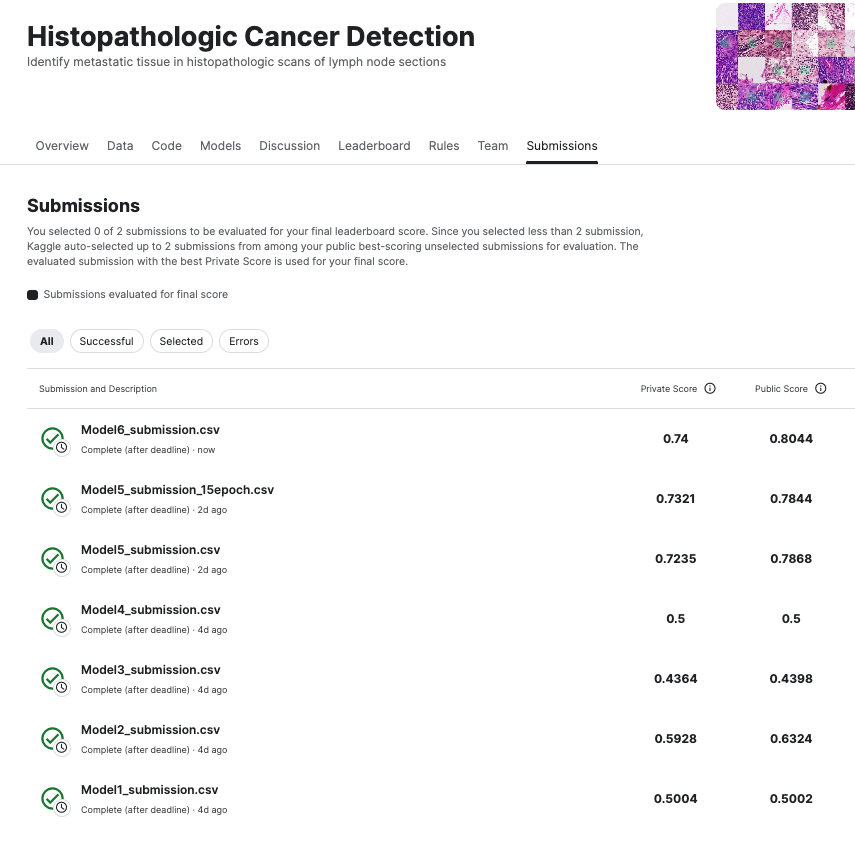